Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3676.015, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3688.335, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3681.376, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3675.192, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3687.233, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3677.009, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3676.837, Time=0.34 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3676.977, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3675.459, Time=0.13 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3678.831, Time=0.72 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3686.235, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3674.579, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3677.097, Time=0.11 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3676.080, Time=0.49 sec
 ARIMA(1,1,1)(1,0,0

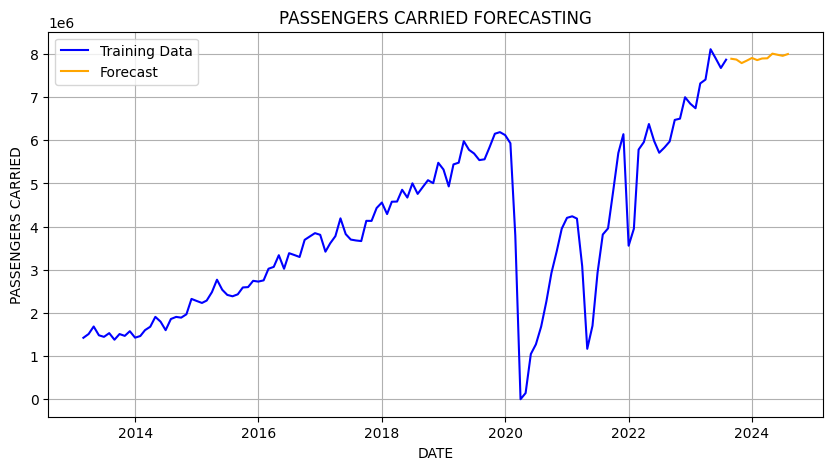

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Load and prepare data
def load_and_prepare_data(filepath, columns_of_interest):
    data = pd.read_csv(filepath)
    data.columns = data.columns.str.strip()
    data['MONTH'] = data['MONTH'].str.strip()

    for col in columns_of_interest:
        data[col] = pd.to_numeric(data[col].replace({",": ""}, regex=True), errors='coerce')

    data.fillna(0, inplace=True)

    month_mapping = {
        'JAN': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'APR': 'Apr', 'MAY': 'May',
        'JUN': 'Jun', 'JUL': 'Jul', 'AUG': 'Aug', 'SEP': 'Sep',
        'OCT': 'Oct', 'NOV': 'Nov', 'DEC': 'Dec'
    }
    data['MONTH'] = data['MONTH'].str[:3].str.upper().map(month_mapping)
    data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + "-" + data['MONTH'], format="%Y-%b")
    data.set_index('DATE', inplace=True)
    data.index = data.index.to_period("M")
    data.sort_index(inplace=True)

    return data

# Function to add lagged features
def add_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['PASSENGERS CARRIED'].shift(lag)
    return data

# Function to fit the SARIMA model
def fit_sarima_model(training_data):
    arima_model = auto_arima(
        training_data,
        seasonal=True,
        m=12,
        stepwise=True,
        trace=True,
        suppress_warnings=True,
        start_p=1,
        start_q=1,
        max_p=5,
        max_d=2,
        max_q=5,
        max_P=3,
        max_D=1,
        max_Q=3,
        information_criterion='aic'
    )
    
    sarima_model = SARIMAX(training_data, order=arima_model.order, seasonal_order=arima_model.seasonal_order)
    sarima_result = sarima_model.fit(disp=False)
    return sarima_result

# Main execution
if __name__ == "__main__":
    filepath = "AirtrafficA4.csv"
    columns_of_interest = [
        "TOTAL DEPARTURES", "HOURS FLOWN", "KILOMETRE FLOWN",
        "PASSENGERS CARRIED", "AVAILABLE SEAT KILOMETRE (IN THOUSAND)",
        "FREIGHT CARRIED (IN TONNE)", "MAIL CARRIED (IN TONNE)"
    ]

    data = load_and_prepare_data(filepath, columns_of_interest)

    # Add lagged features (1 month and 2 months)
    lags = [1, 2]
    data = add_lagged_features(data, lags)

    # Drop rows with NaN values due to lagging
    data.dropna(inplace=True)

    # Extract passengers data and define training set
    npassengers = data['PASSENGERS CARRIED']
    ntraining = npassengers.loc[:'2023-08']

    # Fit model and forecast
    sarima_result = fit_sarima_model(ntraining)
    nforecasted = 12
    forecast = sarima_result.get_forecast(steps=nforecasted)
    forecasted_values = forecast.predicted_mean

    # Ensure the forecast range covers 2023 Sep to 2024 Aug
    forecasted_values.index = pd.period_range(start="2023-09", periods=nforecasted, freq="M")
    
    # Prepare DataFrame for CSV output
    forecast_df = pd.DataFrame({
        'YEAR_MONTH': forecasted_values.index.strftime('%Y %b').str.upper(),
        'PASSENGERS CARRIED': np.round(forecasted_values.clip(lower=0)).astype(int)
    })

    # Write to CSV
    forecast_df.to_csv('best.csv', index=False)

    # Evaluate the model using the last known training data
    last_known_data = npassengers.loc['2023-01':'2023-08']
    predictions = sarima_result.predict(start=last_known_data.index[0], end=last_known_data.index[-1])
    mape = mean_absolute_percentage_error(last_known_data, predictions)
    print(f'MAPE for training data: {mape:.2%}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(ntraining.index.to_timestamp(), ntraining, label='Training Data', color='blue')
    plt.plot(forecasted_values.index.to_timestamp(), forecasted_values, label='Forecast', color='orange')
    plt.title('PASSENGERS CARRIED FORECASTING')
    plt.xlabel('DATE')
    plt.ylabel('PASSENGERS CARRIED')
    plt.legend()
    plt.grid()
    plt.savefig('best.png')
    plt.show()
